# Pneumonia Detection from Chest X-Rays: Complete Pipeline

**What you'll learn:**
1. **DICOM format** — How clinical X-rays are actually stored
2. **Data preprocessing** — Converting DICOMs to training-ready arrays
3. **Transfer learning** — Fine-tuning ResNet18 on medical images
4. **Class imbalance** — The reality of medical datasets
5. **Model interpretability** — Class Activation Maps (CAM) to see *why* the model decided

**Why this matters:**
This is a canonical medical imaging task. Pneumonia detection from chest X-rays is:
- A real clinical need (especially post-COVID)
- A binary classification problem with class imbalance
- A great intro to interpretability (clinicians need to trust AI decisions)

**Dataset:** [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)

---

## Table of Contents

1. [Part 1: Data Preprocessing](#part1)
   - Understanding DICOM format
   - Loading and visualizing X-rays
   - Converting to efficient numpy format
   - Computing dataset statistics

2. [Part 2: Model Training](#part2)
   - PyTorch Lightning crash course
   - Data augmentation for medical images
   - ResNet18 architecture modifications
   - Training and evaluation

3. [Part 3: Interpretability with CAM](#part3)
   - Why interpretability matters in medicine
   - Class Activation Maps explained
   - Visualizing model decisions

---

## Setup

### Install Dependencies (Colab)

In [1]:
# Run this cell in Colab to install required packages
!pip install pydicom pytorch-lightning torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 65.6 MB/s eta 0:00:00


In [7]:
# First, upload your kaggle.json API key to Colab
!pip install kaggle --quiet
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/  # or upload directly
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download -c rsna-pneumonia-detection-challenge
!unzip rsna-pneumonia-detection-challenge.zip -d rsna_data/

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open rsna-pneumonia-detection-challenge.zip, rsna-pneumonia-detection-challenge.zip.zip or rsna-pneumonia-detection-challenge.zip.ZIP.


In [2]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

# Medical imaging
import pydicom

# Deep learning
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchmetrics

# PyTorch Lightning (simplifies training loops)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Data handling
import pandas as pd
import cv2

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
PyTorch Lightning version: 2.6.0
CUDA available: True


In [5]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set paths - ADJUST THESE FOR YOUR SETUP
# Option 1: If you downloaded the Kaggle data
# DATA_ROOT = Path("/content/drive/MyDrive/rsna-pneumonia-detection-challenge")

# Option 2: If using pre-processed data from the course
DATA_ROOT = Path("/content/drive/MyDrive/AI_Medical_Images/04-Pneumonia-classification")

# Where to save processed numpy files
PROCESSED_DIR = Path("Processed")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
<a id='part1'></a>
# Part 1: Data Preprocessing

## What is DICOM?

**DICOM** (Digital Imaging and Communications in Medicine) is the universal standard for medical images. Unlike JPEG or PNG, DICOM files contain:

| Component | Description |
|-----------|-------------|
| **Pixel Data** | The actual image (can be 8-bit, 16-bit, etc.) |
| **Patient Info** | Name, ID, birth date, sex |
| **Study Info** | Date, referring physician, study description |
| **Series Info** | Modality (CT, MR, CR), body part, orientation |
| **Image Info** | Rows, columns, pixel spacing, window center/width |

**Key insight**: DICOM is a *container format* with rich metadata. For ML, we typically extract just the pixel data, but the metadata can be useful for stratification, quality control, etc.

### Privacy Note
Real clinical DICOMs contain PHI (Protected Health Information). The Kaggle dataset has been de-identified, but always be careful with medical data!

---

## Load the Labels

The RSNA challenge provides a CSV with:
- `patientId`: Unique identifier (matches DICOM filename)
- `x, y, width, height`: Bounding box for pneumonia regions (for detection task)
- `Target`: 1 = pneumonia present, 0 = no pneumonia

For our **classification** task, we only need `patientId` and `Target`.

In [60]:
# from google.colab import userdata
# import json

# # Your username is just a string (not sensitive)
# kaggle_username = "christophergaughan"

# # Get the API key from your secret
# kaggle_key = userdata.get('KAGGLE-API')

# # Set up kaggle.json
# !mkdir -p ~/.kaggle

# with open('/root/.kaggle/kaggle.json', 'w') as f:
#     json.dump({"username": kaggle_username, "key": kaggle_key}, f)

# !chmod 600 ~/.kaggle/kaggle.json

# # Verify
# !cat ~/.kaggle/kaggle.json

In [61]:
# from google.colab import userdata

# # Check what the secret looks like (first/last few chars only for security)
# key = userdata.get('KAGGLE-API')
# print(f"Key length: {len(key)}")
# print(f"Key preview: {key[:4]}...{key[-4:]}")

In [25]:
from google.colab import userdata
import os

# New-style token: just set KAGGLE_API_TOKEN
os.environ['KAGGLE_API_TOKEN'] = userdata.get('KAGGLE-API')

# Test
!kaggle competitions list --search rsna

No competitions found


In [26]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

 98% 3.59G/3.66G [00:03<00:00, 834MB/s]
100% 3.66G/3.66G [00:03<00:00, 1.05GB/s]


In [27]:
!unzip -q rsna-pneumonia-detection-challenge.zip -d rsna_data/
!ls rsna_data/

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images
 stage_2_detailed_class_info.csv        stage_2_train_images
 stage_2_sample_submission.csv	        stage_2_train_labels.csv


In [28]:
from pathlib import Path
DATA_ROOT = Path("/content/rsna_data")

# Verify
LABELS_PATH = DATA_ROOT / "stage_2_train_labels.csv"
print(f"Labels file exists: {LABELS_PATH.exists()}")

# Check how many training images
!ls /content/rsna_data/stage_2_train_images/ | wc -l

Labels file exists: True
26684


In [29]:
# Load labels CSV
# Adjust path to where you downloaded the Kaggle data
LABELS_PATH = DATA_ROOT / "stage_2_train_labels.csv"

# If you don't have the raw data, we'll skip preprocessing and use pre-processed files
HAVE_RAW_DATA = LABELS_PATH.exists()
print(f"Raw DICOM data available: {HAVE_RAW_DATA}")

Raw DICOM data available: True


In [30]:
if HAVE_RAW_DATA:
    labels_df = pd.read_csv(LABELS_PATH)
    print(f"Total rows: {len(labels_df)}")
    display(labels_df.head(10))

Total rows: 30227


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

### Handle Duplicate Patient IDs

Some patients have **multiple** pneumonia regions (multiple bounding boxes). For classification, we just need to know "does this patient have pneumonia?" — so we deduplicate.

In [31]:
if HAVE_RAW_DATA:
    print(f"Rows before dedup: {len(labels_df)}")
    labels_df = labels_df.drop_duplicates("patientId")
    print(f"Rows after dedup: {len(labels_df)}")

    # Check class distribution
    print(f"\nClass distribution:")
    print(labels_df['Target'].value_counts())

Rows before dedup: 30227
Rows after dedup: 26684

Class distribution:
Target
0    20672
1     6012
Name: count, dtype: int64


## Visualize Some X-Rays

Let's load a few DICOMs and see what we're working with.

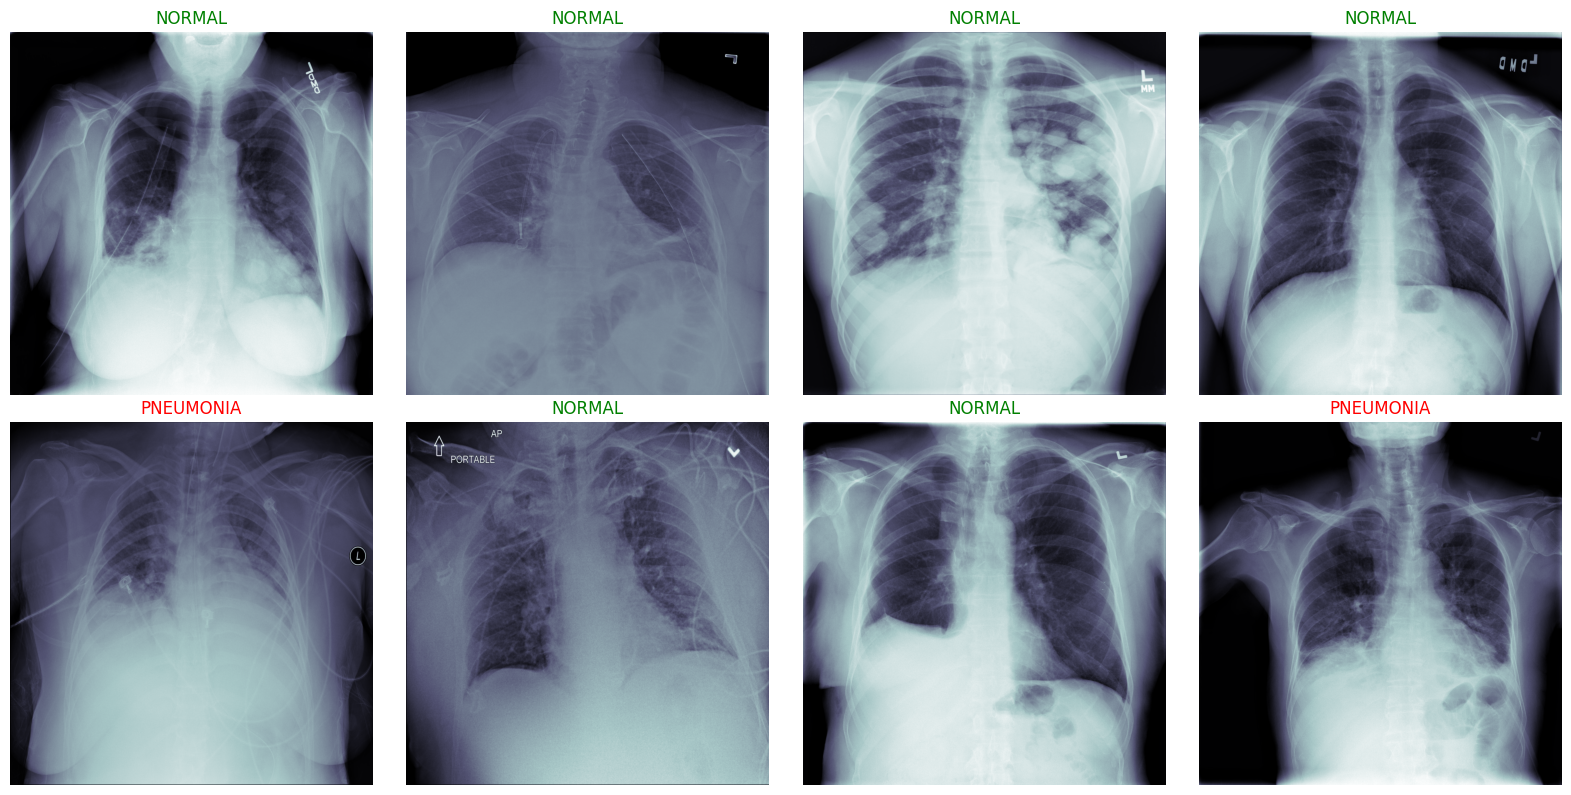


--- DICOM Metadata Example ---
Patient ID: 00704310-78a8-4b38-8475-49f4573b2dbb
Modality: CR
Image shape: (1024, 1024)
Pixel dtype: uint8
Value range: [0, 248]


In [32]:
if HAVE_RAW_DATA:
    DICOM_DIR = DATA_ROOT / "stage_2_train_images"

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        # Get patient ID and label
        patient_id = labels_df['patientId'].iloc[i]
        label = labels_df['Target'].iloc[i]

        # Load DICOM
        dcm_path = DICOM_DIR / f"{patient_id}.dcm"
        dcm = pydicom.dcmread(dcm_path)

        # Display
        ax.imshow(dcm.pixel_array, cmap='bone')
        ax.set_title(f"{'PNEUMONIA' if label == 1 else 'NORMAL'}",
                     color='red' if label == 1 else 'green')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Show DICOM metadata for one file
    print("\n--- DICOM Metadata Example ---")
    print(f"Patient ID: {dcm.PatientID}")
    print(f"Modality: {dcm.Modality}")
    print(f"Image shape: {dcm.pixel_array.shape}")
    print(f"Pixel dtype: {dcm.pixel_array.dtype}")
    print(f"Value range: [{dcm.pixel_array.min()}, {dcm.pixel_array.max()}]")

## Convert DICOMs to NumPy Arrays

For efficient training, we:
1. **Resize** from 1024×1024 to 224×224 (ResNet's expected input size)
2. **Normalize** pixel values to [0, 1]
3. **Save as .npy** files organized by label (for easy PyTorch DatasetFolder loading)
4. **Compute dataset statistics** (mean, std) for normalization during training

### Why This Structure?

```
Processed/
├── train/
│   ├── 0/          # Normal (no pneumonia)
│   │   ├── patient1.npy
│   │   └── ...
│   └── 1/          # Pneumonia
│       ├── patient2.npy
│       └── ...
└── val/
    ├── 0/
    └── 1/
```

This structure lets us use `torchvision.datasets.DatasetFolder` which automatically assigns labels based on folder names.

In [33]:
def preprocess_and_save_dataset(
    labels_df: pd.DataFrame,
    dicom_dir: Path,
    save_dir: Path,
    train_split: int = 24000,
    target_size: tuple = (224, 224)
):
    """
    Convert DICOM files to normalized numpy arrays and save to disk.

    Also computes dataset mean and std for later normalization.

    Args:
        labels_df: DataFrame with 'patientId' and 'Target' columns
        dicom_dir: Path to directory containing .dcm files
        save_dir: Path to save processed .npy files
        train_split: Number of samples for training (rest goes to val)
        target_size: Output image dimensions

    Returns:
        mean, std: Dataset statistics computed on training set only
    """
    # For computing running statistics
    pixel_sum = 0
    pixel_sum_squared = 0
    n_train = 0

    for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Processing DICOMs"):
        patient_id = row['patientId']
        label = row['Target']

        # Load DICOM and extract pixel array
        dcm_path = dicom_dir / f"{patient_id}.dcm"
        dcm = pydicom.dcmread(dcm_path)
        img = dcm.pixel_array.astype(np.float32)

        # Normalize to [0, 1]
        img = img / 255.0

        # Resize
        img = cv2.resize(img, target_size)

        # Convert to float16 to save space
        img = img.astype(np.float16)

        # Determine train/val split
        split = "train" if idx < train_split else "val"

        # Create directory and save
        save_path = save_dir / split / str(label)
        save_path.mkdir(parents=True, exist_ok=True)
        np.save(save_path / f"{patient_id}.npy", img)

        # Accumulate statistics (training set only)
        if split == "train":
            n_pixels = img.shape[0] * img.shape[1]
            pixel_sum += np.sum(img) / n_pixels
            pixel_sum_squared += np.sum(img ** 2) / n_pixels
            n_train += 1

    # Compute mean and std
    mean = pixel_sum / n_train
    std = np.sqrt(pixel_sum_squared / n_train - mean ** 2)

    return float(mean), float(std)

In [34]:
# Only run preprocessing if we have raw data AND haven't already processed
if HAVE_RAW_DATA and not PROCESSED_DIR.exists():
    print("Preprocessing DICOM files...")
    DICOM_DIR = DATA_ROOT / "stage_2_train_images"

    mean, std = preprocess_and_save_dataset(
        labels_df=labels_df,
        dicom_dir=DICOM_DIR,
        save_dir=PROCESSED_DIR,
        train_split=24000
    )

    print(f"\nDataset statistics:")
    print(f"  Mean: {mean:.4f}")
    print(f"  Std:  {std:.4f}")
else:
    # Use pre-computed values from the original notebook
    mean, std = 0.49, 0.248
    print(f"Using pre-computed statistics: mean={mean}, std={std}")

Preprocessing DICOM files...


Processing DICOMs:   0%|          | 0/26684 [00:00<?, ?it/s]


Dataset statistics:
  Mean: 0.0975
  Std:  0.2421


---
<a id='part2'></a>
# Part 2: Model Training

## PyTorch Lightning Crash Course

**PyTorch Lightning** removes boilerplate from PyTorch training. Instead of writing manual training loops, you define:

| Method | Purpose |
|--------|--------|
| `__init__` | Define model architecture |
| `forward` | Forward pass (prediction) |
| `training_step` | Compute loss for one batch |
| `validation_step` | Evaluate on one batch |
| `configure_optimizers` | Define optimizer(s) |

Lightning handles: device management, distributed training, mixed precision, logging, checkpointing.

---

## Data Loading with Augmentation

### Why Data Augmentation?

Medical datasets are often small (compared to ImageNet's 1M+ images). Augmentation artificially expands your dataset by applying random transformations:

- **Rotation**: X-rays aren't always perfectly aligned
- **Translation**: Patient might not be centered
- **Scaling**: Different patient sizes, different distances from detector
- **Random crops**: Forces model to look at local features

**Important**: Only augment training data, NOT validation/test data!

In [35]:
def load_npy(path: str) -> np.ndarray:
    """Load a numpy file and convert to float32."""
    return np.load(path).astype(np.float32)


# Training transforms: augmentation + normalization
train_transforms = transforms.Compose([
    transforms.ToTensor(),  # HxW numpy → 1xHxW tensor, scales to [0,1]
    transforms.Normalize(mean=[mean], std=[std]),  # Z-score normalize
    transforms.RandomAffine(
        degrees=(-5, 5),      # Slight rotation
        translate=(0, 0.05),  # Up to 5% translation
        scale=(0.9, 1.1)      # 90-110% scaling
    ),
    transforms.RandomResizedCrop(
        size=(224, 224),
        scale=(0.35, 1.0)     # Crop 35-100% of image
    )
])

# Validation transforms: normalization only (no augmentation!)
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [36]:
# Create datasets using DatasetFolder
# This automatically assigns labels based on folder names (0, 1)

# Use pre-processed data from course if available
PROCESSED_TRAIN = DATA_ROOT / "Processed" / "train"
PROCESSED_VAL = DATA_ROOT / "Processed" / "val"

# Fallback to local processed dir
if not PROCESSED_TRAIN.exists():
    PROCESSED_TRAIN = PROCESSED_DIR / "train"
    PROCESSED_VAL = PROCESSED_DIR / "val"

print(f"Loading data from: {PROCESSED_TRAIN.parent}")

train_dataset = torchvision.datasets.DatasetFolder(
    root=str(PROCESSED_TRAIN),
    loader=load_npy,
    extensions=('npy',),
    transform=train_transforms
)

val_dataset = torchvision.datasets.DatasetFolder(
    root=str(PROCESSED_VAL),
    loader=load_npy,
    extensions=('npy',),
    transform=val_transforms
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Loading data from: Processed
Training samples: 20993
Validation samples: 5691


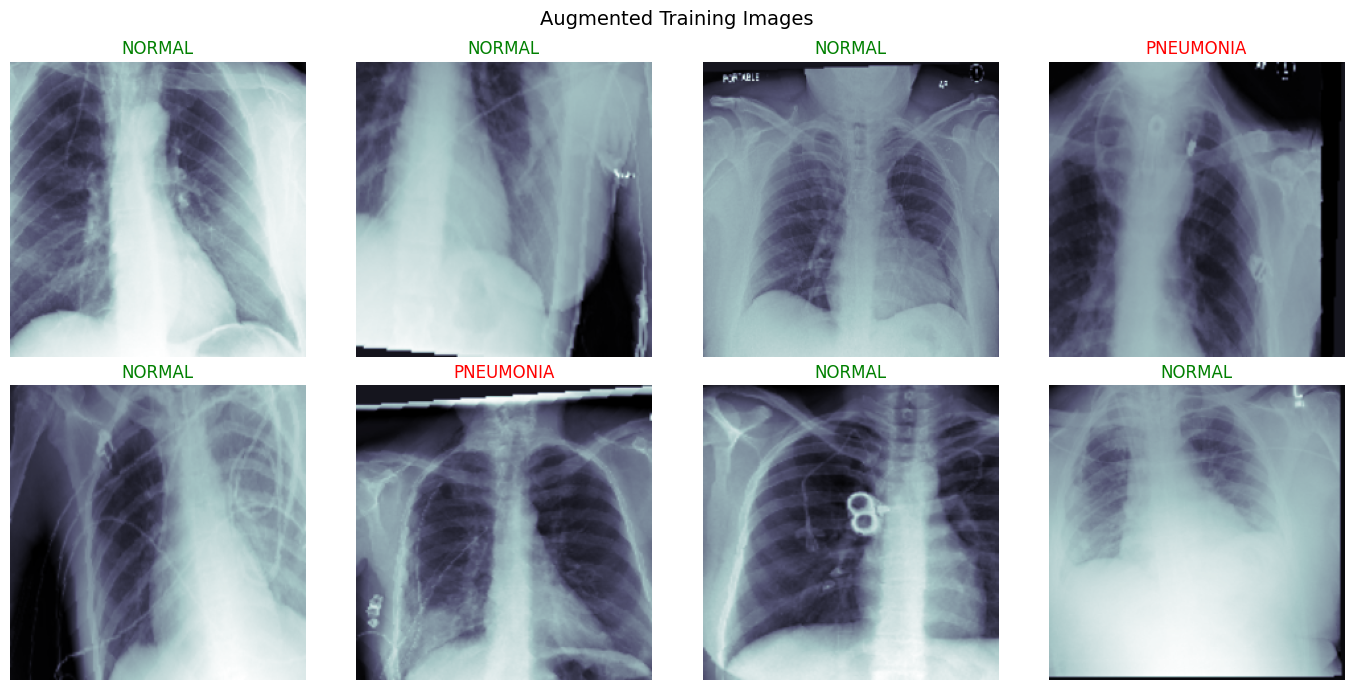

In [37]:
# Visualize some augmented training images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for i, ax in enumerate(axes.flatten()):
    idx = np.random.randint(0, len(train_dataset))
    img, label = train_dataset[idx]

    # img is normalized, so we denormalize for display
    img_display = img[0] * std + mean

    ax.imshow(img_display, cmap='bone')
    ax.set_title(f"{'PNEUMONIA' if label == 1 else 'NORMAL'}",
                 color='red' if label == 1 else 'green')
    ax.axis('off')

plt.suptitle('Augmented Training Images', fontsize=14)
plt.tight_layout()
plt.show()

## Class Imbalance

Medical datasets are almost always imbalanced. Healthy patients outnumber sick ones (thankfully!).

**Options to handle imbalance:**
1. **Weighted loss**: Penalize mistakes on minority class more heavily
2. **Oversampling**: Duplicate minority class samples
3. **Undersampling**: Remove majority class samples
4. **Do nothing**: Sometimes works fine, especially with enough data

For this notebook, we'll use a **weighted loss** as an option.

In [38]:
# Check class distribution
train_targets = np.array(train_dataset.targets)
val_targets = np.array(val_dataset.targets)

print("Training set:")
unique, counts = np.unique(train_targets, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u} ({'Pneumonia' if u == 1 else 'Normal'}): {c} ({100*c/len(train_targets):.1f}%)")

print("\nValidation set:")
unique, counts = np.unique(val_targets, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u} ({'Pneumonia' if u == 1 else 'Normal'}): {c} ({100*c/len(val_targets):.1f}%)")

# Compute class weights for weighted loss
n_normal = np.sum(train_targets == 0)
n_pneumonia = np.sum(train_targets == 1)
pos_weight = n_normal / n_pneumonia
print(f"\nPositive class weight (for BCEWithLogitsLoss): {pos_weight:.2f}")

Training set:
  Class 0 (Normal): 16008 (76.3%)
  Class 1 (Pneumonia): 4985 (23.7%)

Validation set:
  Class 0 (Normal): 4664 (82.0%)
  Class 1 (Pneumonia): 1027 (18.0%)

Positive class weight (for BCEWithLogitsLoss): 3.21


In [39]:
# Create data loaders
BATCH_SIZE = 64  # Adjust based on your GPU memory
NUM_WORKERS = 2  # Adjust based on your CPU cores

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True  # Faster GPU transfer
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

## Model Architecture: ResNet18

We use **ResNet18** pretrained on ImageNet, with two modifications:

1. **Input channels**: Change from 3 (RGB) to 1 (grayscale X-ray)
2. **Output layer**: Change from 1000 classes (ImageNet) to 1 (binary)

### Why Transfer Learning?

Even though ImageNet has cats and dogs (not X-rays), the early layers learn universal features:
- Edges, textures, shapes
- These transfer surprisingly well to medical images

### Binary Classification Setup

For binary classification, we have two options:
1. **2 outputs + CrossEntropyLoss**: Softmax over [P(normal), P(pneumonia)]
2. **1 output + BCEWithLogitsLoss**: Single logit, sigmoid for probability

We use option 2 (more common for binary tasks).

In [40]:
class PneumoniaModel(pl.LightningModule):
    """
    ResNet18-based classifier for pneumonia detection.

    Modifications from standard ResNet18:
    - Input: 1 channel (grayscale) instead of 3 (RGB)
    - Output: 1 logit (binary classification)
    """

    def __init__(self, learning_rate: float = 1e-4, use_weighted_loss: bool = False):
        super().__init__()
        self.save_hyperparameters()  # Saves lr to checkpoint

        # Load pretrained ResNet18
        self.model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

        # Modify first conv layer: 3 channels → 1 channel
        self.model.conv1 = nn.Conv2d(
            in_channels=1,   # Grayscale
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # Modify final FC layer: 1000 classes → 1 output
        self.model.fc = nn.Linear(in_features=512, out_features=1)

        # Loss function
        if use_weighted_loss:
            # Weight positive class more heavily
            self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
        else:
            self.loss_fn = nn.BCEWithLogitsLoss()

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

        self.learning_rate = learning_rate

    def forward(self, x):
        """Forward pass: image → logit."""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Compute loss for one training batch."""
        images, labels = batch
        labels = labels.float()  # BCEWithLogitsLoss expects float

        logits = self(images).squeeze(1)  # Remove extra dimension
        loss = self.loss_fn(logits, labels)

        # Compute accuracy
        probs = torch.sigmoid(logits)
        self.train_acc(probs, labels.int())

        # Log metrics
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Compute loss for one validation batch."""
        images, labels = batch
        labels = labels.float()

        logits = self(images).squeeze(1)
        loss = self.loss_fn(logits, labels)

        probs = torch.sigmoid(logits)
        self.val_acc(probs, labels.int())

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        """Define optimizer."""
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [41]:
# Instantiate model
model = PneumoniaModel(learning_rate=1e-4, use_weighted_loss=False)

# Print model summary
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## Training

In [42]:
# Checkpoint callback: save best models based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    save_top_k=3,
    filename='pneumonia-{epoch:02d}-{val_acc:.3f}'
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=10,  # Increase for better results (original used 35)
    accelerator='auto',  # Automatically use GPU if available
    devices=1,
    callbacks=[checkpoint_callback],
    logger=TensorBoardLogger(save_dir='./logs', name='pneumonia'),
    log_every_n_steps=10
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [44]:
# Train!
trainer.fit(model, train_loader, val_loader)

# Uncomment the line above to actually train.
# For now, we'll load pre-trained weights.

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_p

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet            │ 11.2 M │ train │     0 │
│ 1 │ loss_fn   │ BCEWithLogitsLoss │      0 │ train │     0 │
│ 2 │ train_acc │ BinaryAccuracy    │      0 │ train │     0 │
│ 3 │ val_acc   │ BinaryAccuracy    │      0 │ train │     0 │
└───┴───────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 71                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Check the best checkpoint as it was saved

In [45]:
print(checkpoint_callback.best_model_path)

./logs/pneumonia/version_0/checkpoints/pneumonia-epoch=05-val_acc=0.860.ckpt


## Now run the evaluation cells. Update the weights path to use the freshly trained model:

In [46]:
WEIGHTS_PATH = Path("./logs/pneumonia/version_0/checkpoints/pneumonia-epoch=05-val_acc=0.860.ckpt")

## Load Pre-trained Weights & Evaluate

If you have pre-trained weights from the course, load them here.

In [47]:
# Load YOUR trained model
WEIGHTS_PATH = Path("./logs/pneumonia/version_0/checkpoints/pneumonia-epoch=05-val_acc=0.860.ckpt")

model = PneumoniaModel.load_from_checkpoint(str(WEIGHTS_PATH))
model.eval()
print(f"Loaded weights from: {WEIGHTS_PATH}")

Loaded weights from: logs/pneumonia/version_0/checkpoints/pneumonia-epoch=05-val_acc=0.860.ckpt


In [48]:
# Move model to GPU if available (It is)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [49]:
# Compute predictions on validation set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        logits = model(images).squeeze(1)
        probs = torch.sigmoid(logits).cpu()

        all_preds.extend(probs.tolist())
        all_labels.extend(labels.tolist())

all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels).int()

Evaluating:   0%|          | 0/89 [00:00<?, ?it/s]

In [50]:
# Compute metrics
accuracy = torchmetrics.functional.accuracy(all_preds, all_labels, task='binary')
precision = torchmetrics.functional.precision(all_preds, all_labels, task='binary')
recall = torchmetrics.functional.recall(all_preds, all_labels, task='binary')
f1 = torchmetrics.functional.f1_score(all_preds, all_labels, task='binary')
auroc = torchmetrics.functional.auroc(all_preds, all_labels, task='binary')

print("=" * 40)
print("Validation Metrics (threshold=0.5)")
print("=" * 40)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUROC:     {auroc:.4f}")

Validation Metrics (threshold=0.5)
Accuracy:  0.8600
Precision: 0.6392
Recall:    0.5141
F1 Score:  0.5699
AUROC:     0.8718


### Confusion Matrix

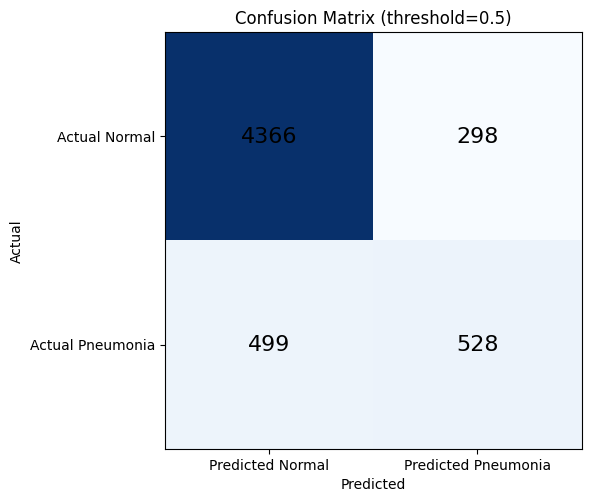


True Negatives (correctly identified healthy): 4366
False Positives (healthy misclassified as pneumonia): 298
False Negatives (pneumonia missed!): 499
True Positives (correctly identified pneumonia): 528

⚠️  499 patients with pneumonia were missed (False Negatives)
In medical settings, we often prefer higher recall (fewer FN) even at the cost of more FP.


In [51]:
from torchmetrics.classification import BinaryConfusionMatrix

# Confusion matrix at threshold 0.5
cm = BinaryConfusionMatrix(threshold=0.5)
cm_result = cm(all_preds, all_labels)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_result, cmap='Blues')

# Labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted Normal', 'Predicted Pneumonia'])
ax.set_yticklabels(['Actual Normal', 'Actual Pneumonia'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Add values
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, f"{cm_result[i, j].item()}",
                       ha='center', va='center', fontsize=16)

plt.title('Confusion Matrix (threshold=0.5)')
plt.tight_layout()
plt.show()

# Explain the confusion matrix
tn, fp, fn, tp = cm_result.flatten().tolist()
print(f"\nTrue Negatives (correctly identified healthy): {tn}")
print(f"False Positives (healthy misclassified as pneumonia): {fp}")
print(f"False Negatives (pneumonia missed!): {fn}")
print(f"True Positives (correctly identified pneumonia): {tp}")

print(f"\n⚠️  {fn} patients with pneumonia were missed (False Negatives)")
print("In medical settings, we often prefer higher recall (fewer FN) even at the cost of more FP.")

### Precision-Recall Tradeoff

By lowering the classification threshold, we can catch more pneumonia cases (higher recall) at the cost of more false alarms (lower precision).

In [52]:
# Compare different thresholds
thresholds = [0.5, 0.25, 0.1]

print("Threshold comparison:")
print("-" * 60)
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 60)

for thresh in thresholds:
    preds_binary = (all_preds >= thresh).int()
    prec = torchmetrics.functional.precision(preds_binary, all_labels, task='binary')
    rec = torchmetrics.functional.recall(preds_binary, all_labels, task='binary')
    f1 = torchmetrics.functional.f1_score(preds_binary, all_labels, task='binary')
    print(f"{thresh:<12} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

Threshold comparison:
------------------------------------------------------------
Threshold    Precision    Recall       F1          
------------------------------------------------------------
0.5          0.6392       0.5141       0.5699      
0.25         0.4761       0.7478       0.5818      
0.1          0.3485       0.9036       0.5030      


---
<a id='part3'></a>
# Part 3: Interpretability with CAM

## Why Interpretability Matters in Medicine

A model that says "pneumonia: 87%" is useful, but clinicians need to know:
- **Where** is the model looking?
- Is it using **valid** features (lung opacities) or **spurious** ones (hospital labels, patient position)?
- Can we **trust** this prediction?

**Class Activation Maps (CAM)** show us which regions of the image contributed most to the prediction.

## How CAM Works

For a CNN ending with:
```
Conv Layer → Global Average Pooling → Fully Connected → Output
```

The CAM is computed as:

$$\text{CAM}(x, y) = \sum_k w_k \cdot A_k(x, y)$$

Where:
- $A_k$ = Feature map k from the last convolutional layer (7×7 for ResNet18)
- $w_k$ = Weight connecting feature map k to the output class

**Intuition**: We're weighting each spatial location by how much each feature map "voted" for the class.

---

In [53]:
class PneumoniaModelCAM(pl.LightningModule):
    """
    Same as PneumoniaModel but modified to return feature maps for CAM.
    """

    def __init__(self):
        super().__init__()

        # Load base model
        self.model = torchvision.models.resnet18()
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(512, 1)

        # Extract feature extractor (everything before avgpool and fc)
        self.feature_extractor = nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, x):
        """
        Returns both prediction and feature maps.
        """
        # Get feature maps (batch, 512, 7, 7)
        features = self.feature_extractor(x)

        # Global average pooling
        pooled = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        pooled = pooled.view(pooled.size(0), -1)  # Flatten: (batch, 512)

        # Classification
        logits = self.model.fc(pooled)

        return logits, features

In [54]:
def compute_cam(model, image: torch.Tensor) -> tuple:
    """
    Compute Class Activation Map for an image.

    Args:
        model: PneumoniaModelCAM instance
        image: Single image tensor (1, H, W)

    Returns:
        cam: Activation map (7, 7)
        prob: Prediction probability
    """
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        # Add batch dimension
        image = image.unsqueeze(0).to(device)

        # Forward pass
        logits, features = model(image)
        prob = torch.sigmoid(logits).item()

        # Features shape: (1, 512, 7, 7)
        # Reshape to (512, 49) for easier computation
        features = features.squeeze(0)  # (512, 7, 7)
        h, w = features.shape[1], features.shape[2]
        features = features.view(512, -1)  # (512, 49)

        # Get FC weights (shape: 1, 512)
        fc_weights = model.model.fc.weight.squeeze()  # (512,)

        # Compute CAM: weighted sum of feature maps
        # cam[i] = sum over k of (weight[k] * feature[k, i])
        cam = torch.matmul(fc_weights, features)  # (49,)

        # Reshape back to spatial dimensions
        cam = cam.view(h, w)  # (7, 7)

        # Normalize to [0, 1]
        cam = cam - cam.min()
        cam = cam / cam.max()

    return cam.cpu(), prob

In [55]:
def visualize_cam(image: torch.Tensor, cam: torch.Tensor, prob: float, label: int):
    """
    Visualize original image alongside CAM overlay.
    """
    # Denormalize image for display
    img = image[0].cpu() * std + mean

    # Resize CAM to image size
    cam_resized = transforms.functional.resize(
        cam.unsqueeze(0),  # Add channel dim
        (224, 224),
        interpolation=transforms.InterpolationMode.BILINEAR
    )[0]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original image
    axes[0].imshow(img, cmap='bone')
    axes[0].set_title('Original X-Ray')
    axes[0].axis('off')

    # CAM heatmap
    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('Class Activation Map')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(img, cmap='bone')
    axes[2].imshow(cam_resized, cmap='jet', alpha=0.5)
    pred_label = 'PNEUMONIA' if prob > 0.5 else 'NORMAL'
    true_label = 'PNEUMONIA' if label == 1 else 'NORMAL'
    axes[2].set_title(f'Overlay\nPred: {pred_label} ({prob:.2f})\nTrue: {true_label}')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [56]:
# Load model for CAM visualization
cam_model = PneumoniaModelCAM()

if WEIGHTS_PATH.exists():
    # Load weights (strict=False because our model structure is slightly different)
    checkpoint = torch.load(WEIGHTS_PATH, map_location='cpu')

    # Extract state dict
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    # Load weights (may need to adjust keys)
    cam_model.load_state_dict(state_dict, strict=False)
    cam_model.eval()
    print("Loaded weights for CAM visualization")
else:
    print("No weights found - CAM visualization will use random weights")

Loaded weights for CAM visualization


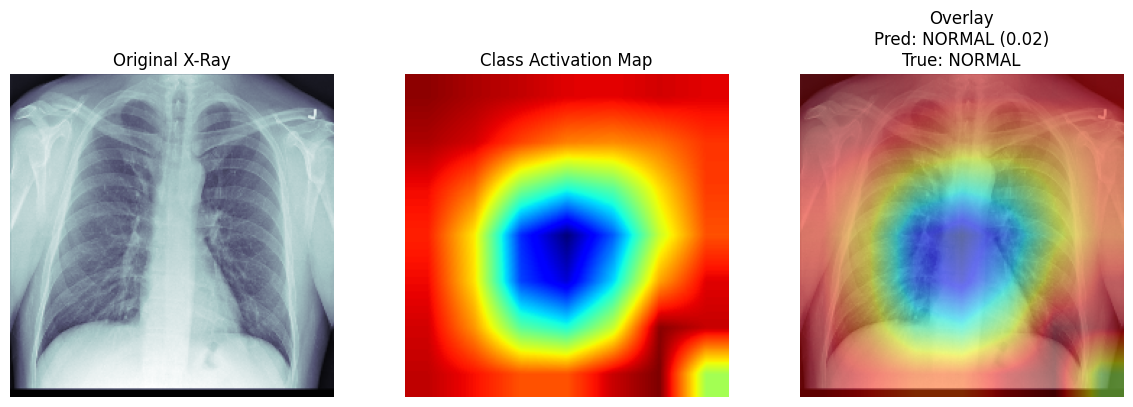

*****


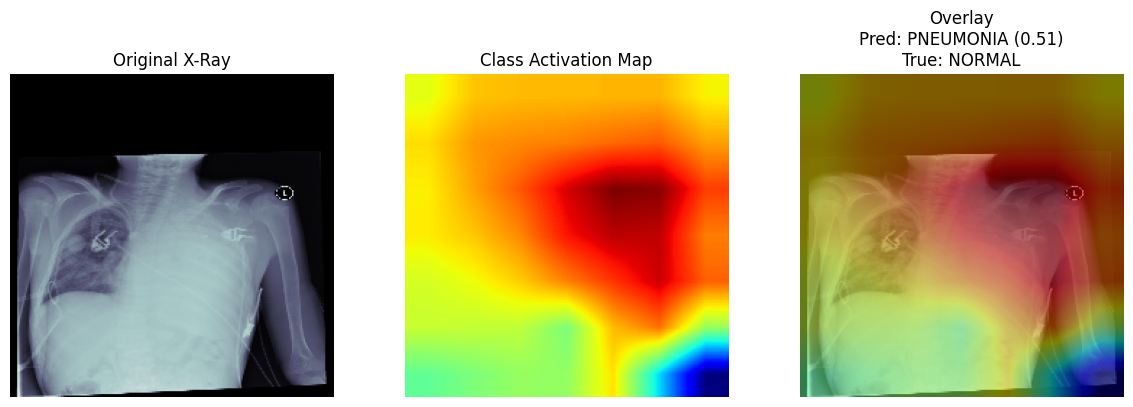

*****


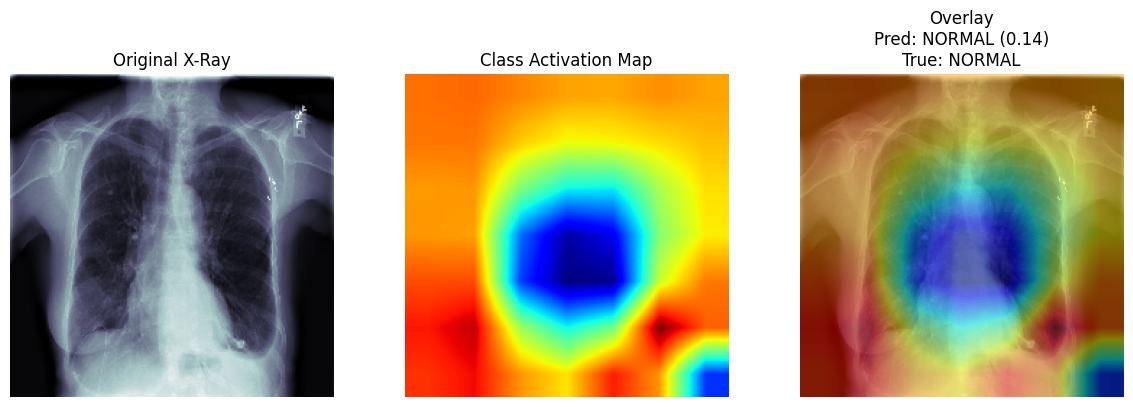

*****


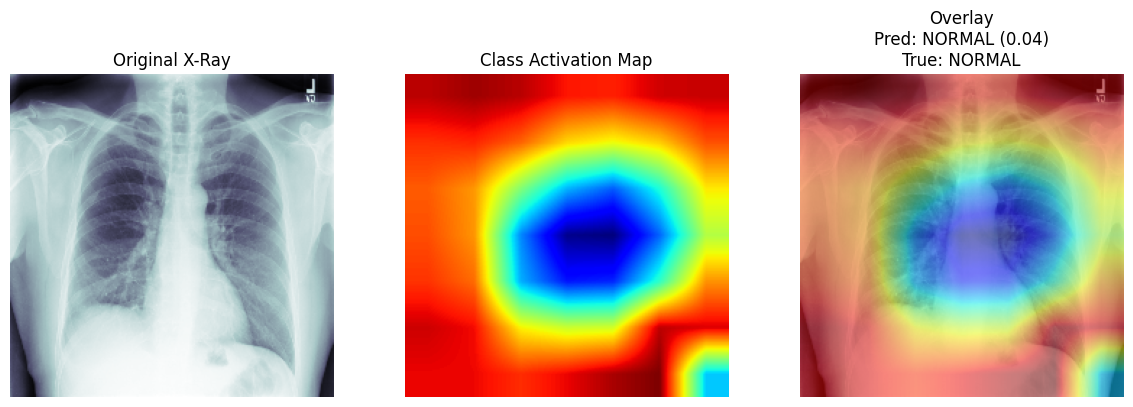

*****


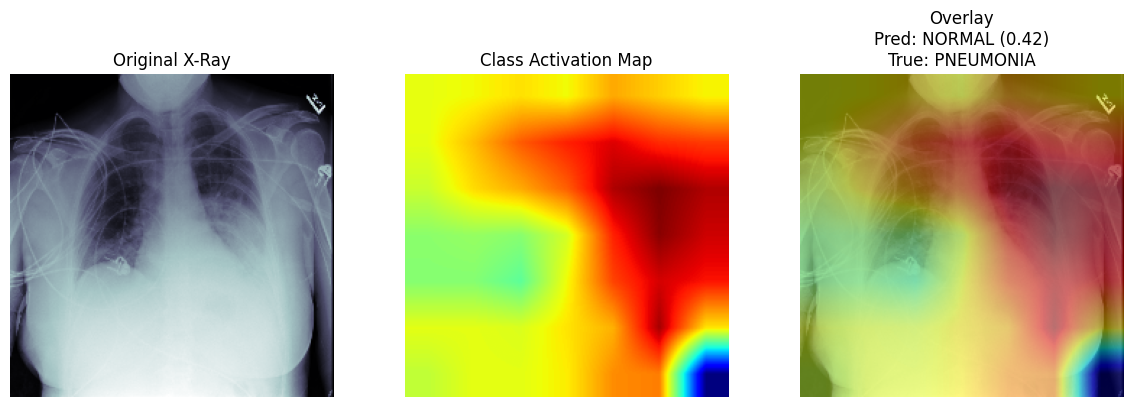

*****


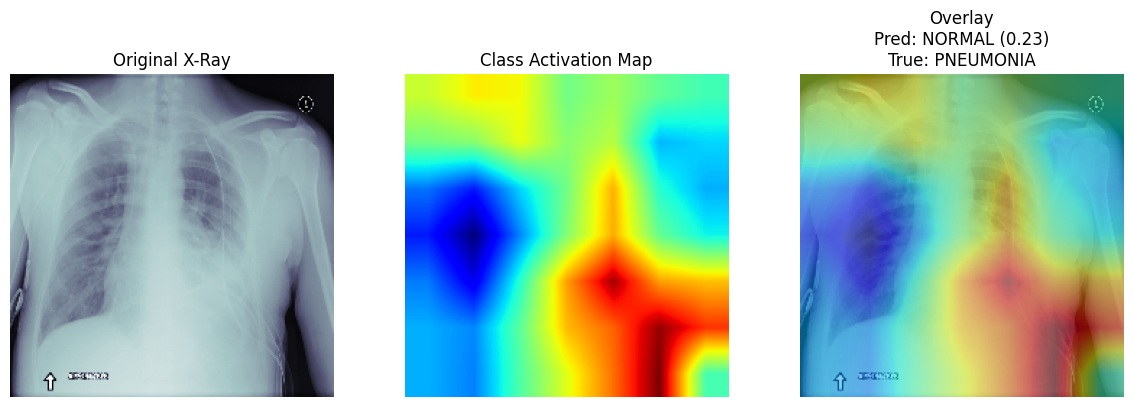

*****


In [59]:
# Visualize CAM for several examples
for i in range(6):
    # Get a random validation image
    idx = np.random.randint(0, len(val_dataset))
    image, label = val_dataset[idx]

    # Compute CAM
    cam_map, prob = compute_cam(cam_model, image)

    # Visualize
    visualize_cam(image, cam_map, prob, label)
    print("*****")

## Interpreting CAM Results

**Good signs:**
- Model focuses on lung regions
- For pneumonia cases, activation is highest in areas with opacities
- For normal cases, attention is more diffuse

**Red flags:**
- Model focuses on corners (might be learning hospital labels/markers)
- Model focuses on patient positioning rather than lung content
- Activation is the same regardless of pathology

### Limitations of CAM

CAM requires a specific architecture: `Conv → GlobalAvgPool → FC`. For other architectures, use:
- **Grad-CAM**: Uses gradients instead of weights (works with any CNN)
- **Score-CAM**: Perturbation-based, gradient-free
- **Integrated Gradients**: Attribution method with theoretical guarantees

---

# Summary

## What We Covered

1. **DICOM preprocessing**: Convert clinical X-rays to training-ready format
2. **Transfer learning**: Adapt ImageNet-pretrained ResNet18 to grayscale medical images
3. **Class imbalance**: Understand the tradeoffs (precision vs recall)
4. **Interpretability**: Use CAM to see what the model is "looking at"

## Key Takeaways

| Topic | Key Point |
|-------|-----------|
| **Data** | Medical data needs careful preprocessing; always check your class distribution |
| **Architecture** | Pretrained CNNs transfer well to medical images with minor modifications |
| **Metrics** | Accuracy isn't enough; consider precision, recall, and clinical implications |
| **Interpretability** | Essential for clinical trust; CAM is simple but powerful |

## Next Steps

- **05-Detection**: Move from classification to object detection (localize the pneumonia)
- **06-Atrium-Segmentation**: Pixel-wise segmentation with U-Net
- **Try different architectures**: EfficientNet, DenseNet, Vision Transformers
- **Explore Grad-CAM**: Works with any architecture (see `pytorch-grad-cam` library)


## Github has a problem with widgets so need to remove

In [62]:
import json
from pathlib import Path

def fix_notebook_for_github(notebook_path):
    """Remove problematic widgets metadata from notebook."""
    with open(notebook_path, 'r') as f:
        nb = json.load(f)

    # Remove widgets metadata if present
    if 'metadata' in nb and 'widgets' in nb['metadata']:
        del nb['metadata']['widgets']

    with open(notebook_path, 'w') as f:
        json.dump(nb, f, indent=1)

    print(f"Fixed: {notebook_path}")